In [1]:
import pickle
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import sys
import math

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 6)

# Магия, чтобы модуль experimental_net импортировался заново при изменениях в нём.
%reload_ext autoreload
%autoreload 2

import toy_net as nn

toy_net reload
toy_net.common reload
toy_net.functions reload
toy_net.optimizers reload
toy_net.net reload


In [47]:
cifar_folder = 'data/cifar-10-batches-py'

labels_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_count = len(labels_names)
print(labels_names)

def load_cifar_batch(folder, file):
    with open(os.path.join(folder, file), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    print(dict[b'batch_label'])
    return dict[b'data'], np.array(dict[b'labels'])

def load_cifar(folder):
    x_tr = list()
    y_tr = list()
    for i in range(1, 6):
        x, y = load_cifar_batch(folder, 'data_batch_' + str(i))
        x_tr.append(x)
        y_tr.append(y)
    x_tr = np.concatenate(x_tr)
    y_tr = np.concatenate(y_tr)
    x_te, y_te = load_cifar_batch(folder, 'test_batch')
    return x_tr, y_tr, x_te, y_te

x_tr, y_tr, x_te, y_te = load_cifar(cifar_folder)
print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
b'training batch 1 of 5'
b'training batch 2 of 5'
b'training batch 3 of 5'
b'training batch 4 of 5'
b'training batch 5 of 5'
b'testing batch 1 of 1'
(50000, 3072) (50000,) (10000, 3072) (10000,)


In [3]:
def plot_image(x, y):
    plt.imshow(x.reshape(3, 32, 32).transpose(1, 2, 0) / 256)
    plt.title(labels_names[y])
    plt.axis('off')

def show_image(x, y):
    plot_image(x, y)
    plt.show()

def show_images(xs, ys):
    n = len(xs)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plot_image(xs[i], ys[i])
    plt.show()

def show_train_images(pos):
    show_images(x_tr[pos:pos+5], y_tr[pos:pos+5])

silence = interact(show_train_images, 
        pos=widgets.BoundedIntText(min=0, max=49999, step=5, value=0, description='Range start:'))

A Jupyter Widget

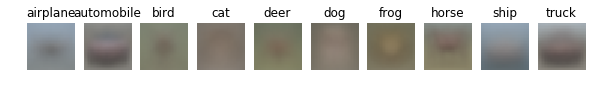

In [4]:
y_mean = range(10)
x_mean = [x_tr[y_tr == y].mean(axis=0) for y in y_mean]
show_images(x_mean, y_mean)

In [5]:
# Аугментация зеркалированием
def flip_images(x):
    result = x.reshape(-1, 3, 32, 32)
    result = result.transpose(0, 2, 3, 1)
    result = np.flip(result, axis=2)
    result = result.transpose(0, 3, 1, 2)
    result = result.reshape(-1, 3 * 32 * 32)
    return result

# Аугментация сдвигом
def shift_images(x, shift, axis):
    y = x.reshape(-1, 3, 32, 32)
    y = np.roll(y, shift, axis=axis)
    return y.reshape(-1, 3 * 32 * 32)

In [6]:
# Perform one hot encoding
y_tr_n = np.eye(label_count)[y_tr]
y_te_n = np.eye(label_count)[y_te]

print(y_tr_n.shape)
print(y_te_n.shape)

x_mean = np.mean(x_tr, axis=0)
print(x_mean.shape)
print(x_tr.shape)
print(x_te.shape)

print('x_mean:', x_mean)
print(x_tr[0])
print(x_te[0])
x_tr_centered = x_tr - x_mean
x_te_centered = x_te - x_mean

x_tr_n = x_tr_centered / 256
x_te_n = x_te_centered / 256
print(x_tr_centered[0])
print(x_te_centered[0])

(50000, 10)
(10000, 10)
(3072,)
(50000, 3072)
(10000, 3072)
x_mean: [ 130.71074  130.14036  131.05044 ...,  113.83058  113.90624  114.38186]
[ 59  43  50 ..., 140  84  72]
[158 159 165 ..., 124 129 110]
[-71.71074 -87.14036 -81.05044 ...,  26.16942 -29.90624 -42.38186]
[ 27.28926  28.85964  33.94956 ...,  10.16942  15.09376  -4.38186]


In [110]:
# Сетка

np.random.seed(5)

reg2 = 0.001
reg_cifar_2D = 0.1
reg3 = None

functions = [
    nn.Matrix(x_tr_n.shape[1], 300, reg2=reg2, reg3=reg3, reg_cifar_2D=reg_cifar_2D),
    nn.Bias(300, reg2=reg2, reg3=reg3),
    nn.Relu(),
    #nn.Dropout(0.1),

    nn.Matrix(300, label_count, reg2=reg2, reg3=reg3),
    nn.Bias(label_count, reg2=reg2, reg3=reg3),
    #nn.SoftMax(),
    #nn.EntropyLoss()
    nn.SvmLoss()
]

net, layers = nn.build_sequence_net(functions, nn.Adam())

In [111]:
output = widgets.Output()
output.layout.height = '380px'
#output.layout.height = '100px'
display(output)

def show_matrix_images():
    w = functions[0].w
    w2 = functions[3].w
    images = w.transpose() * 8000 + 128
    images = np.minimum(255, np.maximum(0, images))
    image_count = images.shape[0]
    column_count = 10
    image_count = min(image_count, 50)
    row_count = math.ceil(image_count / column_count)
    global output
    output.clear_output()
    with(output):
        for i in range(image_count):
            image = images[i]
            plt.subplot(row_count, column_count, i + 1)
            plt.imshow(image.reshape(3, 32, 32).transpose(1, 2, 0) / 256)
            label_index = np.argmax(np.abs(w2[i]))
            label_prefix = '+' if w2[i, label_index] > 0 else '-'
            plt.title(label_prefix + labels_names[label_index])
            plt.axis('off')
        plt.show()


A Jupyter Widget

In [94]:
w = functions[3].w[22].round(2)

print(w)
print(w > 0.2)
print(w < -0.2)
print(labels_names)

#show_matrix_images()

[ 0.    0.    0.09  0.    0.   -0.   -0.    0.    0.   -0.  ]
[False False False False False False False False False False]
[False False False False False False False False False False]
['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [117]:
def train_epoch(speed, x_tr_a, y_tr_a):
    permutation = np.random.permutation(x_tr_a.shape[0])
    x_tr_a = x_tr_a[permutation]
    y_tr_a = y_tr_a[permutation]

    loss_before = net.calculate_loss([x_tr_a], y_tr_a)
    
    batch_size = 1000
    train_len = x_tr_a.shape[0]
    for i in range(0, train_len // batch_size):
        batch_start = i * batch_size
        batch_end = min(train_len, batch_start + batch_size)
        x_batch = x_tr_a[batch_start:batch_end]
        y_batch = y_tr_a[batch_start:batch_end]

        loss = net.train([x_batch], y_batch, speed)

        sys.stdout.write('\rTrain. Batch: %d, loss %f' % (i, loss))
        sys.stdout.flush()

    loss_after = net.calculate_loss([x_tr_a], y_tr_a)
    sys.stdout.write('\rEpoch complete. Loss before: %f, after: %f, change: %f\n' 
        % (loss_before, loss_after, loss_after - loss_before))
    sys.stdout.flush()
    print('Accuracy tr:', net.calculate_accuracy([x_tr_a], y_tr_a))
    print('Accuracy te:', net.calculate_accuracy([x_te_n], y_te_n))

    functions[0].trace_statistics()
    functions[3].trace_statistics()
    show_matrix_images()

speed = 0.001

for i in range(1):
    train_epoch(speed, x_tr_n, y_tr_n)
    train_epoch(speed, flip_images(x_tr_n), y_tr_n)
    train_epoch(speed, x_tr_n, y_tr_n)
    print('Done')

"""
for i in range(1):
    train_epoch(speed, x_tr_n, y_tr_n)
    train_epoch(speed, flip_images(x_tr_n), y_tr_n)
    train_epoch(speed, shift_images(x_tr_n, 1, axis=2), y_tr_n)
    train_epoch(speed, x_tr_n, y_tr_n)
    train_epoch(speed, shift_images(x_tr_n, -1, axis=2), y_tr_n)
    train_epoch(speed, flip_images(x_tr_n), y_tr_n)
    train_epoch(speed, shift_images(x_tr_n, 1, axis=3), y_tr_n)
    train_epoch(speed, x_tr_n, y_tr_n)
    train_epoch(speed, shift_images(x_tr_n, -1, axis=3), y_tr_n)
    train_epoch(speed, flip_images(x_tr_n), y_tr_n)
    train_epoch(speed, x_tr_n, y_tr_n)
    print('Done')
"""

Epoch complete. Loss before: 2.487582, after: 2.420108, change: -0.067473
Accuracy tr: 0.56586
Accuracy te: 0.5362
  Matrix columns statistics: mean: [-0.0041, 0.0030], std: [0.0027, 0.0233], log10: [-2.57, -1.63]
  Matrix columns statistics: mean: [-0.0263, 0.0189], std: [0.0853, 0.1210], log10: [-1.07, -0.92]
Epoch complete. Loss before: 2.657811, after: 2.458804, change: -0.199007
Accuracy tr: 0.56232
Accuracy te: 0.5404
  Matrix columns statistics: mean: [-0.0037, 0.0033], std: [0.0026, 0.0232], log10: [-2.58, -1.63]
  Matrix columns statistics: mean: [-0.0275, 0.0189], std: [0.0864, 0.1228], log10: [-1.06, -0.91]
Epoch complete. Loss before: 2.543005, after: 2.420584, change: -0.122421
Accuracy tr: 0.56382
Accuracy te: 0.5392
  Matrix columns statistics: mean: [-0.0041, 0.0033], std: [0.0028, 0.0232], log10: [-2.56, -1.63]
  Matrix columns statistics: mean: [-0.0273, 0.0194], std: [0.0874, 0.1245], log10: [-1.06, -0.90]
Done


"\nfor i in range(1):\n    train_epoch(speed, x_tr_n, y_tr_n)\n    train_epoch(speed, flip_images(x_tr_n), y_tr_n)\n    train_epoch(speed, shift_images(x_tr_n, 1, axis=2), y_tr_n)\n    train_epoch(speed, x_tr_n, y_tr_n)\n    train_epoch(speed, shift_images(x_tr_n, -1, axis=2), y_tr_n)\n    train_epoch(speed, flip_images(x_tr_n), y_tr_n)\n    train_epoch(speed, shift_images(x_tr_n, 1, axis=3), y_tr_n)\n    train_epoch(speed, x_tr_n, y_tr_n)\n    train_epoch(speed, shift_images(x_tr_n, -1, axis=3), y_tr_n)\n    train_epoch(speed, flip_images(x_tr_n), y_tr_n)\n    train_epoch(speed, x_tr_n, y_tr_n)\n    print('Done')\n"

In [114]:
functions[0].reg2 = 0.001
functions[0].reg3 = 0
functions[0].reg_cifar_2D = 0.5

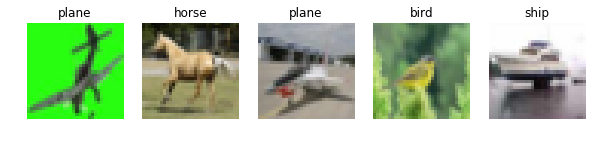

In [138]:
w = functions[0].w
wp = np.dot(x_tr_n, w)
wm = np.argmax(wp, axis=0)
pos = wm[15]
show_images(x_tr[pos:pos+5], y_tr[pos:pos+5])